In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from persim import plot_diagrams
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [15]:
"""Import dataset"""

# Import data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [16]:
"""Preprocess Data: Remove Duplicates and Missing Values"""

# Check initial counts
initial_count = X.shape[0]

# Remove duplicates
X_clean = X.drop_duplicates()
y_clean = y.loc[X_clean.index]
duplicates_removed = initial_count - X_clean.shape[0]

# Remove missing values
after_duplicates = X_clean.shape[0]
mask = ~X_clean.isnull().any(axis=1)
X_clean = X_clean[mask]
y_clean = y_clean[mask]
missing_removed = after_duplicates - X_clean.shape[0]

# Summary
print(f"Original shape: {initial_count}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Missing values removed: {missing_removed}")
print(f"Total removed: {duplicates_removed + missing_removed}")
print(f"Cleaned shape: {X_clean.shape[0]}")

# Update X and y
X = X_clean.reset_index(drop=True)
y = y_clean.reset_index(drop=True)

Original shape: 303
Duplicates removed: 0
Missing values removed: 6
Total removed: 6
Cleaned shape: 297


In [17]:
"""Standardize the Features"""

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame

In [18]:
"""Compute Euclidean distance matrix"""

distance_matrix = pairwise_distances(X_scaled, metric='euclidean')


H0 (connected components): 297 features
H1 (loops/cycles): 261 features
H2 (voids): 182 features


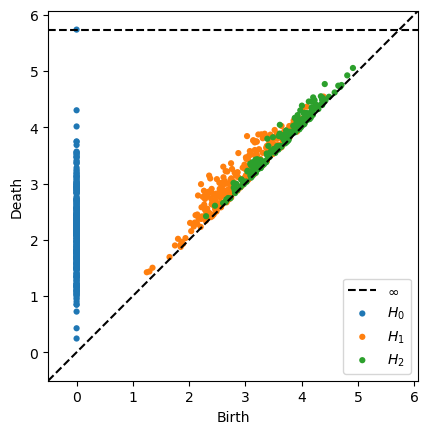

In [19]:
"""Vietoris-Rips Filtration and Persistent Homology Computation"""

# Vietoris-Rips filtration set-up
max_dimension = 2  # Up to 2-dimensional homology (H0, H1, H2)
max_edge_length = np.percentile(distance_matrix[distance_matrix > 0], 50)  # Use median distance

# Compute persistent homology
result = ripser(distance_matrix, maxdim=max_dimension, distance_matrix=True)

# Extract persistence diagrams
diagrams = result['dgms']

# Print out H0, H1, H2
print(f"\nH0 (connected components): {len(diagrams[0])} features")
print(f"H1 (loops/cycles): {len(diagrams[1])} features")
print(f"H2 (voids): {len(diagrams[2])} features")

# Plot persistence diagrams
plot_diagrams(diagrams, show=True)

Stable Rank (Betti) curves computed!
Epsilon range: [0, 4.9730] with 100 steps


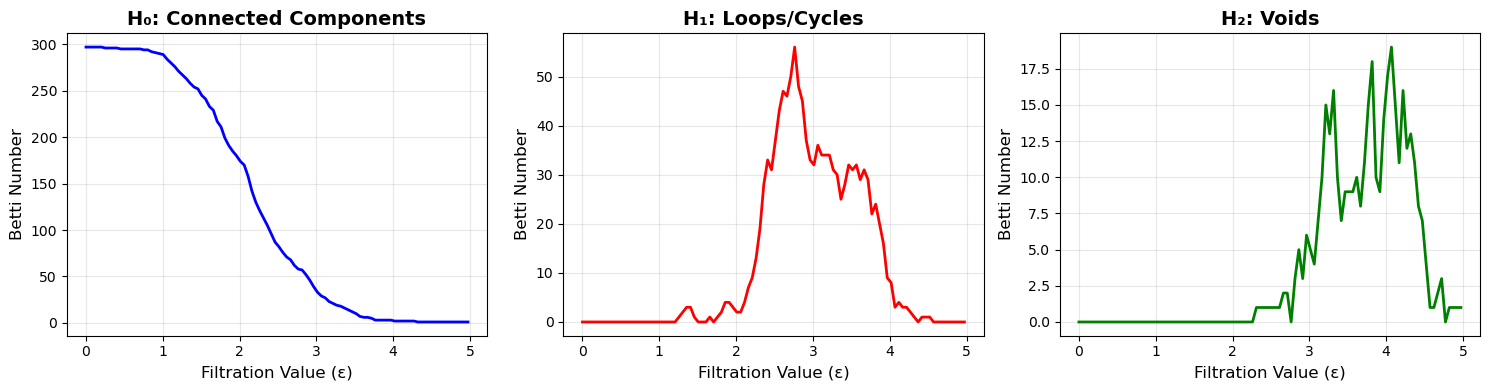

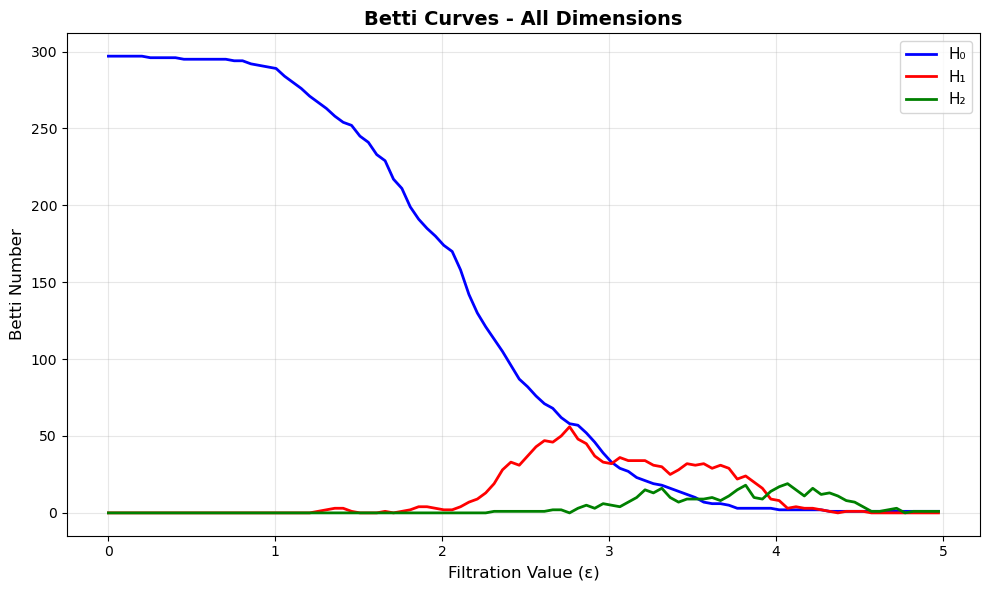

In [33]:
"""Betti Curves Computation and Visualization"""

# Filtration scales
epsilon_values = np.linspace(0, max_edge_length, 100)

# Compute Betti numbers 
betti_0 = [np.sum((diagrams[0][:,0] <= eps) & (diagrams[0][:,1] > eps)) for eps in epsilon_values]
betti_1 = [np.sum((diagrams[1][:,0] <= eps) & (diagrams[1][:,1] > eps)) for eps in epsilon_values]
betti_2 = [np.sum((diagrams[2][:,0] <= eps) & (diagrams[2][:,1] > eps)) for eps in epsilon_values] if len(diagrams) > 2 else []

print("Stable Rank (Betti) curves computed!")
print(f"Epsilon range: [0, {max_edge_length:.4f}] with {len(epsilon_values)} steps")

# Plot individual Betti curves
titles = ['H₀: Connected Components', 'H₁: Loops/Cycles', 'H₂: Voids']
colors = ['b', 'r', 'g']
bettis = [betti_0, betti_1, betti_2]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    if i < len(bettis) and len(bettis[i]) > 0:
        ax.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2)
    else:
        ax.text(0.5, 0.5, 'No features', ha='center', va='center')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Filtration Value (ε)', fontsize=12)
    ax.set_ylabel('Betti Number', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(10, 6))
for i in range(len(bettis)):
    if len(bettis[i]) > 0:
        plt.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2, label=titles[i].split(":")[0])
plt.xlabel('Filtration Value (ε)', fontsize=12)
plt.ylabel('Betti Number', fontsize=12)
plt.title('Betti Curves - All Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
"""L1 Norm (Persistence) computation for each homology dimension"""

# H0
persistence_0 = diagrams[0][:, 1] - diagrams[0][:, 0]
persistence_0 = persistence_0[np.isfinite(persistence_0)]

# H1
persistence_1 = diagrams[1][:, 1] - diagrams[1][:, 0]
persistence_1 = persistence_1[np.isfinite(persistence_1)]

# H2
persistence_2 = diagrams[2][:, 1] - diagrams[2][:, 0]
persistence_2 = persistence_2[np.isfinite(persistence_2)]

# Sum 
l1_norm_0 = persistence_0.sum()  
l1_norm_1 = persistence_1.sum() 
l1_norm_2 = persistence_2.sum()

# Print
print("\nL1 Distances (Persistence Lifetimes):")
print(f"H0 persistence — Mean: {persistence_0.mean():.4f}, Min: {persistence_0.min():.4f}, Max: {persistence_0.max():.4f}")
print(f"H1 persistence — Mean: {persistence_1.mean():.4f}, Min: {persistence_1.min():.4f}, Max: {persistence_1.max():.4f}")
print(f"H2 persistence — Mean: {persistence_2.mean():.4f}, Min: {persistence_2.min():.4f}, Max: {persistence_2.max():.4f}")
print("\nL1 Norms (Total Persistence):")
print(f"H0: {l1_norm_0}, \nH1: {l1_norm_1}, \nH2: {l1_norm_2}")



L1 Distances (Persistence Lifetimes):
H0 persistence — Mean: 2.1493, Min: 0.2448, Max: 4.3016
H1 persistence — Mean: 0.2303, Min: 0.0005, Max: 0.8127
H2 persistence — Mean: 0.1049, Min: 0.0009, Max: 0.4307

L1 Norms (Total Persistence):
H0: 636.199797347188, 
H1: 60.10834014415741, 
H2: 19.09399938583374


Random Forest — Raw Data
Binary Classification Accuracy: 88.33%
Multi-Class Classification Accuracy: 60.00%


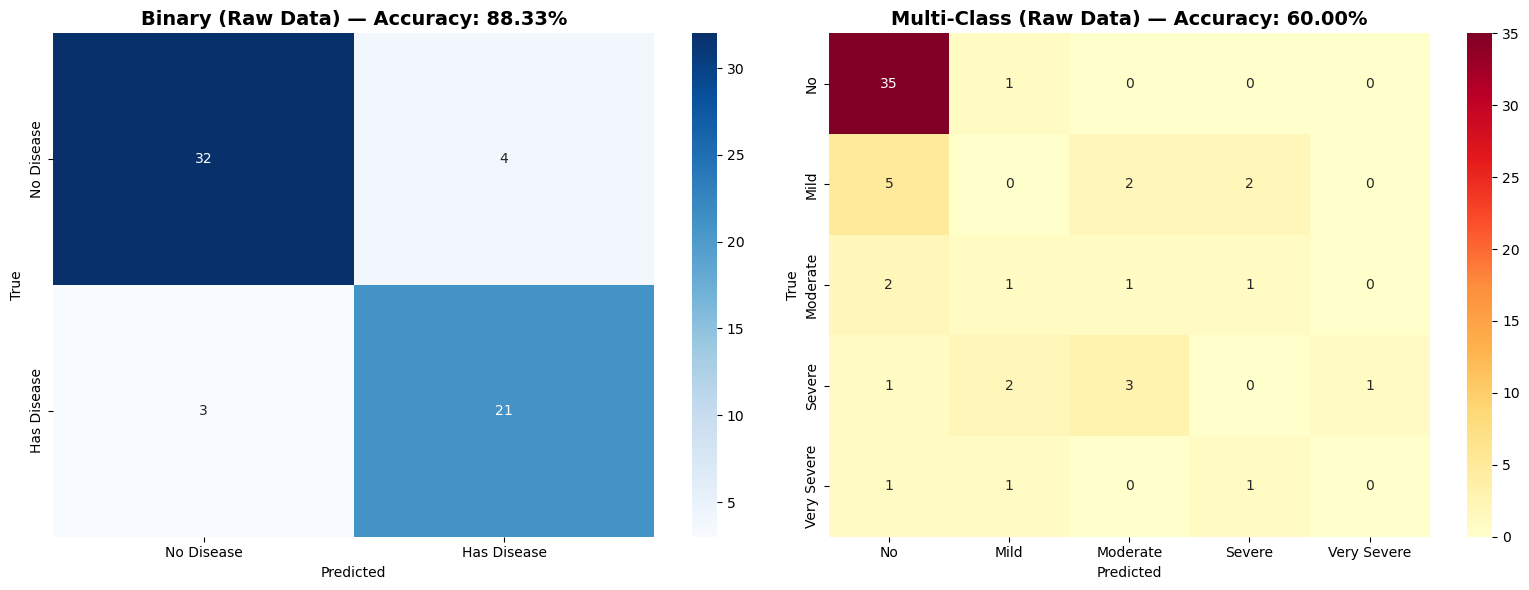

In [9]:
"""Random Forest Classification Using Raw Data"""

# Binary classification (y > 0 = has disease)
y_binary = (y > 0).astype(int)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = clf_bin.predict(X_test_bin)
acc_bin = accuracy_score(y_test_bin, y_pred_bin)

# Multi-class classification (0–4 severity)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
clf_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = clf_multi.predict(X_test_multi)
acc_multi = accuracy_score(y_test_multi, y_pred_multi)

# Print results
print("Random Forest — Raw Data")
print(f"Binary Classification Accuracy: {acc_bin:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_multi:.2%}")

# Plot confusion matrices 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'],
            ax=axes[0])
axes[0].set_title(f'Binary (Raw Data) — Accuracy: {acc_bin:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            ax=axes[1])
axes[1].set_title(f'Multi-Class (Raw Data) — Accuracy: {acc_multi:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Random Forest — Topological Features
Binary Classification Accuracy: 86.67%
Multi-Class Classification Accuracy: 60.00%


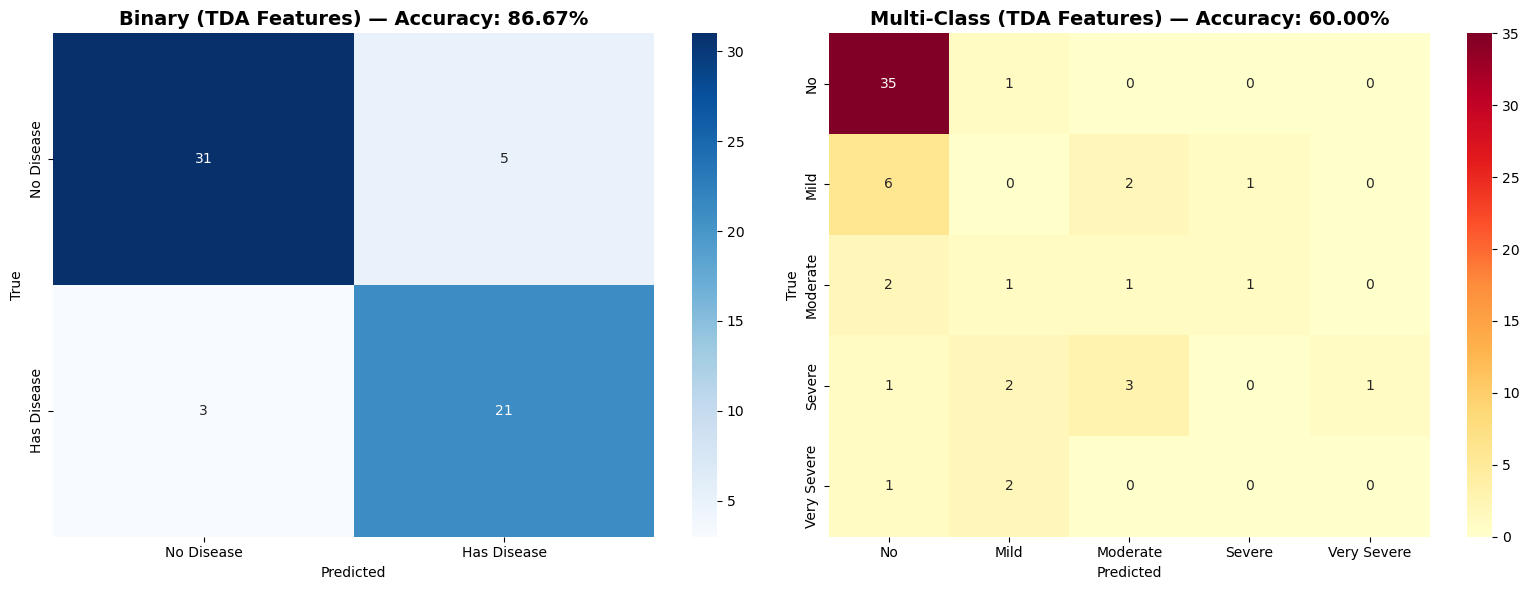

In [10]:
"""Random Forest with Topological Features"""

# Define a function to compute barcode summary stats 
def barcode_summary(diagram):
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    if len(lifetimes) == 0:
        return [0, 0, 0, 0, 0, 0]
    p = lifetimes / lifetimes.sum()
    entropy = -(p * np.log(p)).sum()
    return [
        len(lifetimes),
        lifetimes.sum(),
        lifetimes.max(),
        lifetimes.mean(),
        lifetimes.std(ddof=0),
        entropy,
    ]

# Extract barcode summaries for each homology dimension
features = []
for dgm in diagrams:
    features.extend(barcode_summary(dgm))

X_topo = np.array(features).reshape(1, -1)
y_binary = (y > 0).astype(int)

# Split data
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
X_train_b_tda = np.hstack([X_train_b, np.repeat(X_topo, len(X_train_b), axis=0)])
X_test_b_tda  = np.hstack([X_test_b, np.repeat(X_topo, len(X_test_b), axis=0)])
X_train_m_tda = np.hstack([X_train_m, np.repeat(X_topo, len(X_train_m), axis=0)])
X_test_m_tda  = np.hstack([X_test_m, np.repeat(X_topo, len(X_test_m), axis=0)])

clf_b = RandomForestClassifier(n_estimators=300, random_state=42)
clf_b.fit(X_train_b_tda, y_train_b)
y_pred_b = clf_b.predict(X_test_b_tda)
acc_b = accuracy_score(y_test_b, y_pred_b)

clf_m = RandomForestClassifier(n_estimators=300, random_state=42)
clf_m.fit(X_train_m_tda, y_train_m)
y_pred_m = clf_m.predict(X_test_m_tda)
acc_m = accuracy_score(y_test_m, y_pred_m)

# Print results
print("Random Forest — Topological Features")
print(f"Binary Classification Accuracy: {acc_b:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_m:.2%}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'], ax=axes[0])
axes[0].set_title(f'Binary (TDA Features) — Accuracy: {acc_b:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'], ax=axes[1])
axes[1].set_title(f'Multi-Class (TDA Features) — Accuracy: {acc_m:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


# Clusters and Subgroups

In [11]:
"""Compute per-patient topological feature vectors"""

# Params
k_neighbors = 25
maxdim = 2 

# Compute a TDA feature vector for each patient
tda_features = []
for i in tqdm(range(len(X_scaled))):
    neigh_idx = np.argsort(distance_matrix[i])[:k_neighbors]
    local_dist = distance_matrix[np.ix_(neigh_idx, neigh_idx)]
    result = ripser(local_dist, distance_matrix=True, maxdim=maxdim)
    dgms = result["dgms"]
    fvec = []
    for dgm in dgms:
        fvec.extend(barcode_summary(dgm))
    tda_features.append(fvec)

X_topo = np.array(tda_features)

# Feature names for later use
tda_feature_names = [
    "H0_count", "H0_sum", "H0_max", "H0_mean", "H0_std", "H0_entropy",
    "H1_count", "H1_sum", "H1_max", "H1_mean", "H1_std", "H1_entropy"
]

100%|██████████| 297/297 [00:00<00:00, 4206.31it/s]


In [12]:
"""Explaining TDA Features"""

tda_feature_names = [
    "H0_count", "H0_sum", "H0_max", "H0_mean", "H0_std", "H0_entropy",
    "H1_count", "H1_sum", "H1_max", "H1_mean", "H1_std", "H1_entropy",
    "H2_count", "H2_sum", "H2_max", "H2_mean", "H2_std", "H2_entropy"
]
print(f"TDA features: {tda_feature_names}")
print("\nWhat the TDA features mean:")
print("H0_x: Connectivity of components (how many distinct groups and how long they persist).")
print("H1_x: Loops or cycles (capturing circular or periodic structures in patient data).")
print("H2_x: Cavities or higher-dimensional voids (less common but may indicate complex shapes).")
print("\nPatients with similar topological summaries = similar global data geometry.")

TDA features: ['H0_count', 'H0_sum', 'H0_max', 'H0_mean', 'H0_std', 'H0_entropy', 'H1_count', 'H1_sum', 'H1_max', 'H1_mean', 'H1_std', 'H1_entropy', 'H2_count', 'H2_sum', 'H2_max', 'H2_mean', 'H2_std', 'H2_entropy']

What the TDA features mean:
H0_x: Connectivity of components (how many distinct groups and how long they persist).
H1_x: Loops or cycles (capturing circular or periodic structures in patient data).
H2_x: Cavities or higher-dimensional voids (less common but may indicate complex shapes).

Patients with similar topological summaries = similar global data geometry.


In [13]:
"""Cluster Patients Using TDA Features"""

num_clusters = 4 # Number of clusters

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_topo)

for i in range(num_clusters):
    n = np.sum(clusters == i)
    print(f"  Subgroup {i}: {n} patients ({n / len(clusters) * 100:.1f}%)")

  Subgroup 0: 57 patients (19.2%)
  Subgroup 1: 89 patients (30.0%)
  Subgroup 2: 64 patients (21.5%)
  Subgroup 3: 87 patients (29.3%)


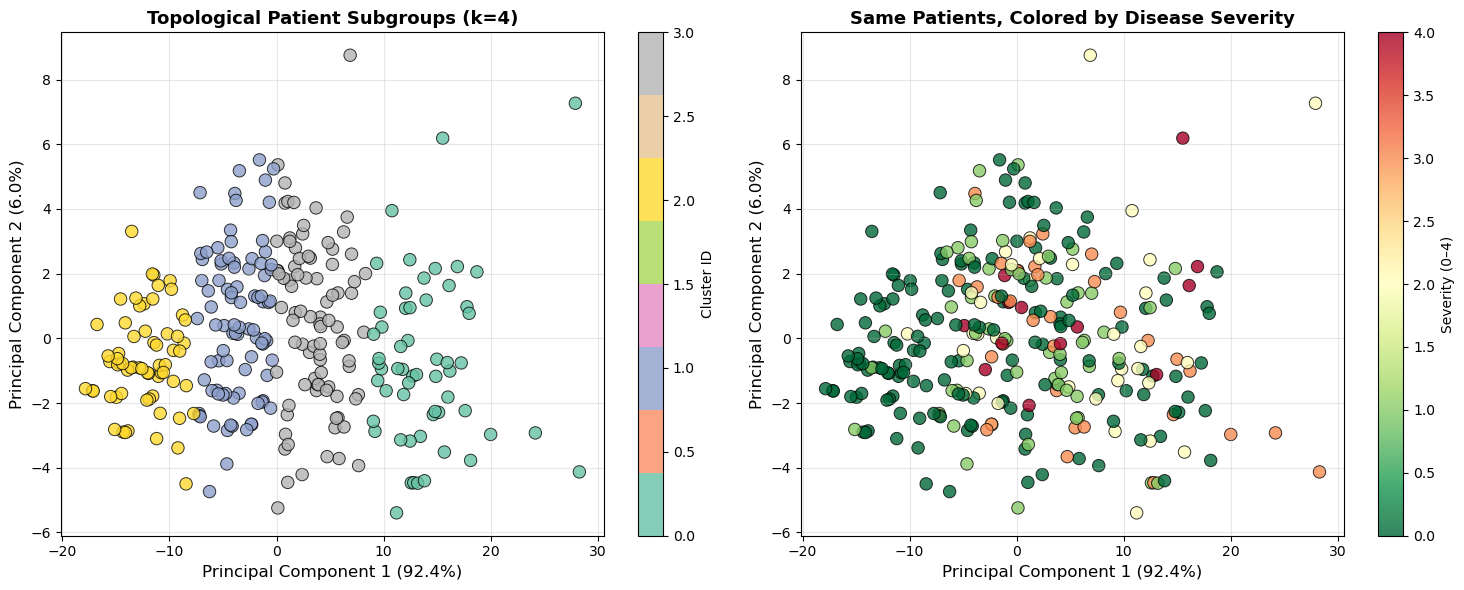

In [14]:
"""Visualize Topological Subgroups"""

y_flat = y.values.ravel() if hasattr(y, 'values') else y

# Dimensionality reduction with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_topo)
expl_var = pca.explained_variance_ratio_ * 100

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: clusters in TDA space
scatter1 = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=clusters, cmap='Set2',
    s=80, alpha=0.8, edgecolors='black', linewidth=0.7
)
axes[0].set_xlabel(f'Principal Component 1 ({expl_var[0]:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'Principal Component 2 ({expl_var[1]:.1f}%)', fontsize=12)
axes[0].set_title(f'Topological Patient Subgroups (k={num_clusters})',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID')

# Right Plot: same as left but colored by disease severity 
scatter2 = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_flat, cmap='RdYlGn_r',
    s=80, alpha=0.8, edgecolors='black', linewidth=0.7
)
axes[1].set_xlabel(f'Principal Component 1 ({expl_var[0]:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'Principal Component 2 ({expl_var[1]:.1f}%)', fontsize=12)
axes[1].set_title('Same Patients, Colored by Disease Severity',
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Severity (0–4)')

plt.tight_layout()
plt.show()

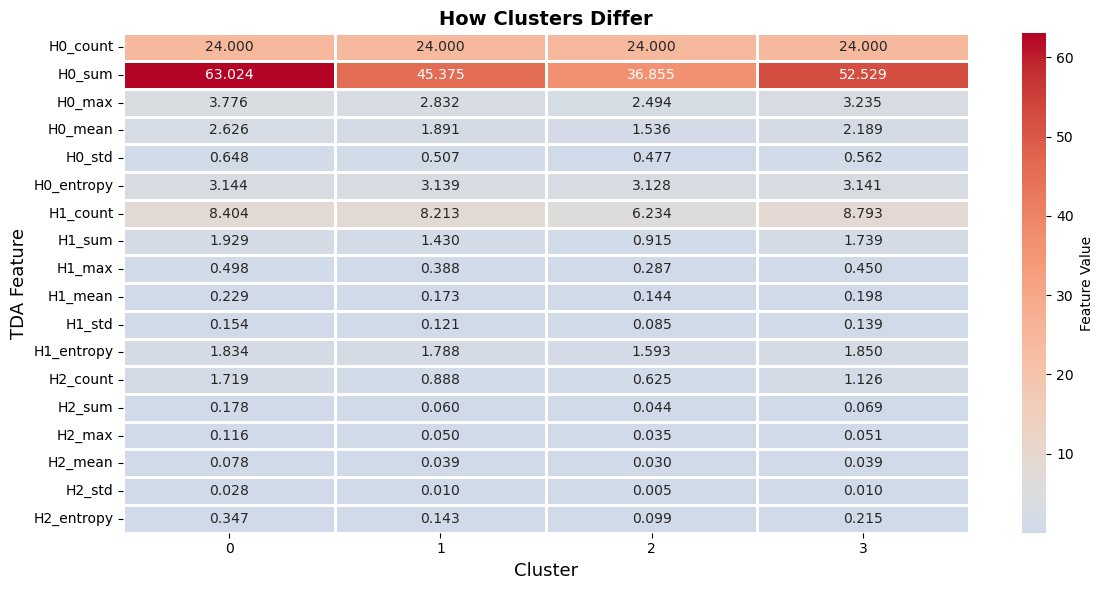

In [15]:
"""Cluster Explanation"""

# Df
tda_df = pd.DataFrame(X_topo, columns=tda_feature_names)
tda_df["Cluster"] = clusters

cluster_centers = kmeans.cluster_centers_

# Visual comparison of cluster features in a heatmap
plt.figure(figsize=(12, 6))
tda_summary = tda_df.groupby("Cluster").mean()
sns.heatmap(
    tda_summary.T, annot=True, fmt=".3f", cmap="coolwarm",
    cbar_kws={"label": "Feature Value"}, linewidths=1, center=tda_summary.values.mean()
)
plt.xlabel("Cluster", fontsize=13)
plt.ylabel("TDA Feature", fontsize=13)
plt.title("How Clusters Differ", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [16]:
"""Map Topological Clusters to Clinical Features"""

FEATURE_INFO = {
    'age': ('Age', 'years', 'continuous'),
    'sex': ('Sex', '1=male, 0=female', 'categorical'),
    'cp': ('Chest Pain Type', '1-4', 'categorical'),
    'trestbps': ('Resting Blood Pressure', 'mm Hg', 'continuous'),
    'chol': ('Cholesterol', 'mg/dl', 'continuous'),
    'fbs': ('Fasting Blood Sugar', '1=yes, 0=no', 'categorical'),
    'restecg': ('Resting ECG', '0-2', 'categorical'),
    'thalach': ('Maximum Heart Rate Achieved', 'bpm', 'continuous'),
    'exang': ('Exercise Included Angina', '1=yes, 0=no', 'categorical'),
    'oldpeak': ('ST Depression Induced By Exercise Relative To Rest', 'units', 'continuous'),
    'slope': ('ST Slope', '1-3', 'categorical'),
    'ca': ('Number Of Major Vessels (0-3) Colored By Flourosopy', '0-3', 'categorical'),
    'thal': ('Thalassemia', '3/6/7', 'categorical')
}

for cluster_id in range(num_clusters):
    mask = clusters == cluster_id
    
    print(f"\n{'━'*80}")
    print(f"CLUSTER {cluster_id}: {mask.sum()} patients ({mask.sum()/len(clusters)*100:.1f}%)")
    print(f"{'━'*80}")
   
    # Disease severity distribution 
    severity = y_flat[mask]
    print(f"\nDisease Severity Distribution:")
    for sev in range(5):
        count = np.sum(severity == sev)
        if count > 0:
            print(f"    Level {sev}: {count} patients ({count/len(severity)*100:.1f}%)")
    avg_sev = severity.mean()
    print(f"Average severity: {avg_sev:.2f}", end="")
    if avg_sev > y_flat.mean() + 0.3:
        print(" (HIGHER than average)")
    elif avg_sev < y_flat.mean() - 0.3:
        print(" (LOWER than average)")
    else:
        print(" (similar to average)")
    
    # Demographics 
    print(f"\nDemographics:")
    if 'age' in X.columns:
        age_mean = X.loc[mask, 'age'].mean()
        age_overall = X['age'].mean()
        print(f"    Age: {age_mean:.1f} years", end="")
        if abs(age_mean - age_overall) > 5:
            print(f" ({'older' if age_mean > age_overall else 'younger'} than avg {age_overall:.1f})")
        else:
            print(" (similar to avg)")
    
    if 'sex' in X.columns:
        male_pct = (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100
        overall_male_pct = (X['sex'] == 1).sum() / len(X) * 100
        print(f"    Gender: {male_pct:.0f}% male", end="")
        if abs(male_pct - overall_male_pct) > 15:
            print(f" ({'MORE' if male_pct > overall_male_pct else 'LESS'} male than avg {overall_male_pct:.0f}%)")
        else:
            print(" (similar to avg)")
    
    # Clinical features (continuous)
    print(f"\nClinical Features (Continous):")
    differences = []
    for col in X.columns:
        if col in FEATURE_INFO and FEATURE_INFO[col][2] == 'continuous':
            group_mean = X.loc[mask, col].mean()
            overall_mean = X[col].mean()
            overall_std = X[col].std()
            if overall_std > 0:
                diff_sigma = (group_mean - overall_mean) / overall_std
                if abs(diff_sigma) > 0.5:
                    name, unit, _ = FEATURE_INFO[col]
                    direction = "HIGHER" if diff_sigma > 0 else "LOWER"
                    differences.append((abs(diff_sigma),
                        f"{name}: {group_mean:.1f} {unit} ({direction}, {abs(diff_sigma):.1f}σ from avg)"))
    differences.sort(reverse=True)
    if differences:
        for rank, (_, desc) in enumerate(differences[:5], 1):
            print(f"    {rank}. {desc}")
    else:
        print("    • No strong continuous deviations from population average.")
    
    # Clinical features (categorical)
    print(f"\nClinical Features (Categorical):")
    for col in ['cp', 'exang', 'ca']:
        if col in X.columns:
            cluster_mode = X.loc[mask, col].mode()[0] if len(X.loc[mask, col].mode()) > 0 else None
            mode_pct = (X.loc[mask, col] == cluster_mode).sum() / mask.sum() * 100 if cluster_mode is not None else 0
            if mode_pct > 60: 
                name, _, _ = FEATURE_INFO[col]
                print(f"    • {name}: {mode_pct:.0f}% have value {int(cluster_mode)}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
CLUSTER 0: 57 patients (19.2%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Disease Severity Distribution:
    Level 0: 24 patients (42.1%)
    Level 1: 5 patients (8.8%)
    Level 2: 15 patients (26.3%)
    Level 3: 9 patients (15.8%)
    Level 4: 4 patients (7.0%)
Average severity: 1.37 (HIGHER than average)

Demographics:
    Age: 59.1 years (similar to avg)
    Gender: 63% male (similar to avg)

Clinical Features (Continous):
    1. ST Depression Induced By Exercise Relative To Rest: 1.7 units (HIGHER, 0.5σ from avg)
    2. Age: 59.1 years (HIGHER, 0.5σ from avg)

Clinical Features (Categorical):

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
CLUSTER 1: 89 patients (30.0%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Disease Severity Distribution:
    Level 0: 39 patients (43.8%)
    Level 1: 2